In [12]:
%load_ext autoreload
%autoreload 2


In [4]:
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
from crops_package.data import split_data

In [14]:
data = pd.read_csv(f"{os.environ.get('DATA_PATH')}data.csv")
data['filename'] = os.environ.get("LOCAL_PATH") + data['filename']
data['class'] = data['class'].astype(str)

In [16]:
train_df, val_df, test_df = split_data(data)

In [6]:
len(train_df)

1814

In [7]:
from crops_package.data import preprocessor_df
train_generator = preprocessor_df(train_df)
val_generator = preprocessor_df(val_df)

Found 1814 validated image filenames belonging to 22 classes.
Found 321 validated image filenames belonging to 22 classes.


# Model initialization

In [8]:
from tensorflow.keras import layers
from tensorflow.keras import models

def initialize_model():
    model = models.Sequential()

    ### First Convolution & MaxPooling
    model.add(layers.Conv2D(32, (4,4), input_shape=(224, 224, 3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### Second Convolution & MaxPooling
    # model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
    # model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### Flattening
    model.add(layers.Flatten())

    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(layers.Dense(2, activation='relu'))

    ### Last layer - Classification Layer with 10 outputs corresponding to 10 digits
    model.add(layers.Dense(22, activation='softmax'))

    ### Model compilation
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

# fit model with earlystopping

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

model_small = initialize_model()

es = EarlyStopping(patience = 5, verbose = 2)

history_small = model_small.fit(train_generator,
                    validation_data = val_generator,
                    callbacks = [es],
                    epochs = 3,
                    batch_size = 64)

Epoch 1/3
57/57 [==============================] - 24s 417ms/step - loss: 3.0839 - accuracy: 0.0937 - val_loss: 3.0770 - val_accuracy: 0.1433
Epoch 2/3
57/57 [==============================] - 20s 352ms/step - loss: 3.0698 - accuracy: 0.1064 - val_loss: 3.0642 - val_accuracy: 0.1433
Epoch 3/3
57/57 [==============================] - 20s 359ms/step - loss: 3.0568 - accuracy: 0.1064 - val_loss: 3.0527 - val_accuracy: 0.1433


In [10]:
model_small.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 401408)            0         
                                                                 
 dense (Dense)               (None, 2)                 802818    
                                                                 
 dense_1 (Dense)             (None, 22)                66        
                                                                 
Total params: 804452 (3.07 MB)
Trainable params: 804452 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [80]:
model_small.save("/home/mahaut/code/MahautHDL/save_the_crops/models")

INFO:tensorflow:Assets written to: /home/mahaut/code/MahautHDL/save_the_crops/models/assets


INFO:tensorflow:Assets written to: /home/mahaut/code/MahautHDL/save_the_crops/models/assets


## Plotting History

In [11]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

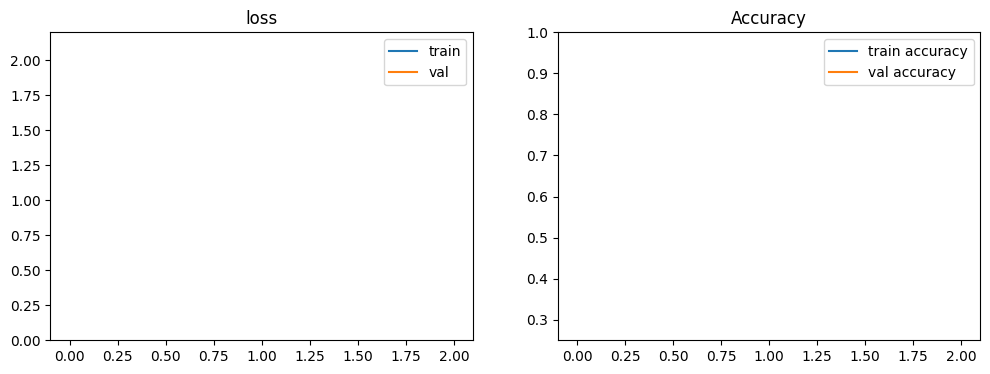

In [12]:
plot_history(history_small)
plt.show()

## EVALUATING

In [13]:
from crops_package.data import preprocessor_test

In [14]:
test_generator = preprocessor_test(test_df)

Found 377 validated image filenames belonging to 22 classes.


In [15]:
res = model_small.evaluate(test_generator, verbose = 0)
res


[3.0576109886169434, 0.07957559823989868]

## PREDICTIONS

In [67]:
index = 0
filepath = list(test_df['filename'])[index]
filename = list(test_df['class'])[index]

In [68]:
from crops_package.data import prepocessor_img
img_processed = prepocessor_img(filepath)

In [79]:
predictions = model_small.predict(img_processed)
predictions

1/1 [==============================] - 0s 41ms/step


array([[0.05047547, 0.0409847 , 0.04653547, 0.04872178, 0.04955043,
        0.05176306, 0.04728018, 0.04323137, 0.0464432 , 0.04619545,
        0.04010019, 0.04249613, 0.03959728, 0.04544985, 0.04268042,
        0.04710782, 0.04398467, 0.04091262, 0.04918309, 0.04170329,
        0.05211484, 0.04348872]], dtype=float32)

In [70]:
class_names = list(train_generator.class_indices.keys())
class_names


['Cashew anthracnose',
 'Cashew gumosis',
 'Cashew healthy',
 'Cashew leaf miner',
 'Cashew red rust',
 'Cassava bacterial blight',
 'Cassava brown spot',
 'Cassava green mite',
 'Cassava healthy',
 'Cassava mosaic',
 'Maize fall armyworm',
 'Maize grasshoper',
 'Maize healthy',
 'Maize leaf beetle',
 'Maize leaf blight',
 'Maize leaf spot',
 'Maize streak virus',
 'Tomato healthy',
 'Tomato leaf blight',
 'Tomato leaf curl',
 'Tomato septoria leaf spot',
 'Tomato verticulium wilt']

In [71]:
print(f"{class_names[np.argmax(predictions)]} - {np.max(predictions)* 100:.2f}%")

Tomato septoria leaf spot - 5.21%


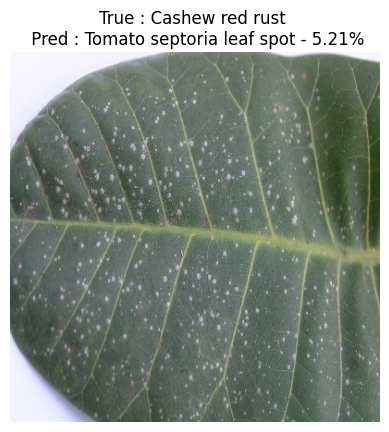

In [78]:
img = plt.imread(filepath)

plt.imshow(img)
plt.axis(False)
plt.title(f"True : {filename} \n Pred : {class_names[np.argmax(predictions)]} - {np.max(predictions)* 100:.2f}%")
plt.show()


In [72]:
external_path="https://res.cloudinary.com/compo-com/image/fetch/c_fill,g_xy_center,f_auto,w_708,h_531,x_iw_mul_50_div_100,y_ih_mul_42_div_100/https://www.compo.de/dam/jcr:0f172ae7-9fb3-4fd2-be8b-810d3582da05/sweet-corn_Maiskolben.jpg"
img2_processed = prepocessor_img(external_path)

In [73]:
predictions2 = model_small.predict(img2_processed)
predictions2

1/1 [==============================] - 0s 37ms/step


array([[0.05047547, 0.0409847 , 0.04653547, 0.04872178, 0.04955043,
        0.05176306, 0.04728018, 0.04323137, 0.0464432 , 0.04619545,
        0.04010019, 0.04249613, 0.03959728, 0.04544985, 0.04268042,
        0.04710782, 0.04398467, 0.04091262, 0.04918309, 0.04170329,
        0.05211484, 0.04348872]], dtype=float32)

In [74]:
print(f"{class_names[np.argmax(predictions2)]} - {np.max(predictions2)* 100:.2f}%")

Tomato septoria leaf spot - 5.21%
